In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
import calendar
from datetime import datetime
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
#Read in the data
data = pd.read_csv("Lekagul Sensor Data.csv")
data

,Timestamp,car-id,car-type,gate-name
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2
...,...,...,...,...
171472,2016-05-31 23:40:13,20161031111001-854,6,ranger-stop2
171473,2016-05-31 23:42:08,20165831105856-579,1,general-gate4
171474,2016-05-31 23:43:13,20161031111001-854,6,general-gate1
171475,2016-05-31 23:49:45,20165831105856-579,1,general-gate7


In [4]:
#Check each column's data type
data.dtypes

Timestamp    object
car-id       object
car-type     object
gate-name    object
dtype: object

In [5]:
#Check for nulls
data.isna().sum()

Timestamp    0
car-id       0
car-type     0
gate-name    0
dtype: int64

In [6]:
#Change variables to appropriate type
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['car-type'] = data['car-type'].astype('category')
data['gate-name'] = data['gate-name'].astype('category')

# separate out by months and weekdays to see trends
data['month'] = [d.strftime('%b') for d in data.Timestamp]
data['day'] = [calendar.day_name[int(d.weekday())] for d in data.Timestamp]
data['days'] = [d.weekday() for d in data.Timestamp]
data['hours'] = [d.hour for d in data.Timestamp]
data['months'] = [d.month for d in data.Timestamp]

# reduce cars and gate types

data['gates'] = np.where(data['gate-name'].str.startswith('entrance'), 'entrance',   
                 np.where(data['gate-name'].str.startswith('general'),'general_gate',
                  np.where(data['gate-name'].str.startswith('gate'), 'gate',
                           np.where(data['gate-name'].str.startswith('ranger'),'ranger_stop',
                                   np.where(data['gate-name'].str.startswith('camping'), 'camping', 0)))))

data['cars'] = np.where(data['car-type'] == '1', 'car',
                       np.where(data['car-type']=='2P','park_truck',
                               np.where((data['car-type']=='2') | (data['car-type']=='3')| (data['car-type']=='4'), 'truck',
                                       np.where((data['car-type']=='5') | (data['car-type']=='6'), 'bus', 0))))
data.head()


,Timestamp,car-id,car-type,gate-name,month,day,days,hours,months,gates,cars
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3,May,Friday,4,0,5,entrance,truck
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1,May,Friday,4,1,5,general_gate,truck
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2,May,Friday,4,1,5,ranger_stop,truck
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0,May,Friday,4,1,5,ranger_stop,truck
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2,May,Friday,4,1,5,general_gate,truck


In [7]:
#Check each column's data type again
data.dtypes

Timestamp    datetime64[ns]
car-id               object
car-type           category
gate-name          category
month                object
day                  object
days                  int64
hours                 int64
months                int64
gates                object
cars                 object
dtype: object

In [8]:
#Describe the statistics of the base data
data.describe()

,days,hours,months
count,171477.000000,171477.000000,171477.000000
mean,3.109776,12.458866,6.966153
std,2.015854,5.061303,2.104184
min,0.000000,0.000000,1.000000
25%,1.000000,9.000000,6.000000
50%,3.000000,12.000000,7.000000
75%,5.000000,16.000000,8.000000
max,6.000000,23.000000,12.000000


array([[<AxesSubplot:title={'center':'Timestamp'}>,
        <AxesSubplot:title={'center':'days'}>],
       [<AxesSubplot:title={'center':'hours'}>,
        <AxesSubplot:title={'center':'months'}>]], dtype=object)

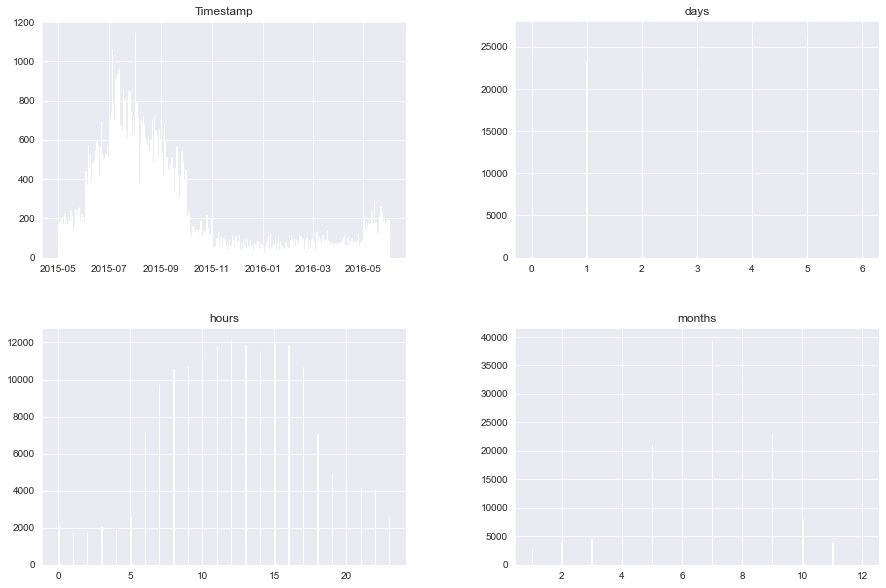

In [164]:
#Visualize distribution of each column & outliers
data.hist(bins=1000, figsize=(15, 10))

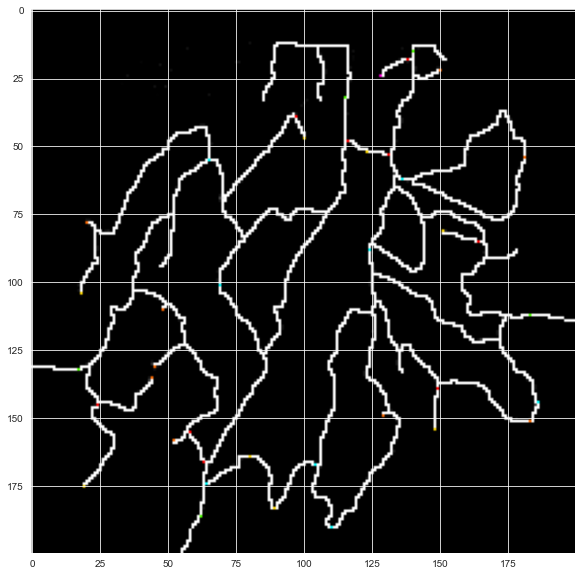

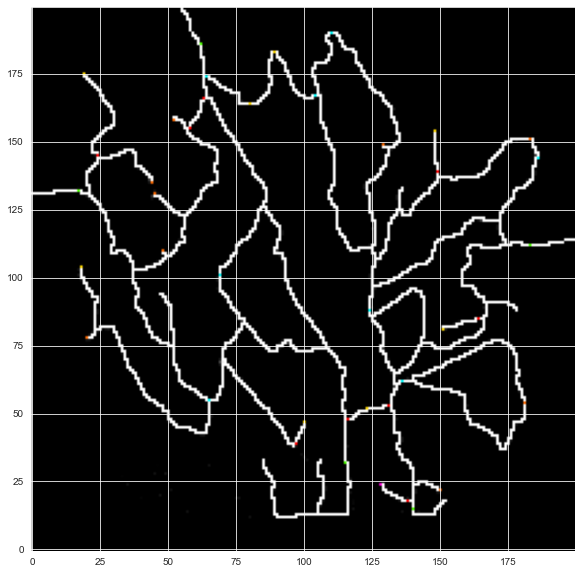

(<matplotlib.image.AxesImage at 0x154efcc10>, None, None)

In [165]:
#load in bmp
img = cv2.imread('Lekagul Roadways.bmp')
flip = img[::-1,:,:]
pixel_values = flip[:,:,::-1]
plt.imshow(flip[:,:,::-1],vmin=0,vmax=255), plt.show()
plt.imshow(flip[:,:,::-1]), plt.gca().invert_yaxis(), plt.show()

In [166]:
#color names

# (0, 0, 0), black
#  (0, 255, 255), cyan
#  (1, 1, 1), black
#  (2, 2, 2), black
#  (3, 3, 3), black
#  (5, 5, 5), black
#  (6, 6, 6), black
#  (8, 8, 8), black
#  (9, 9, 9), black
#  (14, 14, 14), black
#  (16, 16, 16),black
#  (17, 17, 17),black
#  (18, 18, 18),black
#  (19, 19, 19),black
#  (20, 20, 20),black
#  (21, 21, 21),black
#  (22, 22, 22),black
#  (23, 23, 23),black
#  (24, 24, 24),black
#  (25, 25, 25),black
#  (31, 31, 31),black
#  (46, 46, 46),black
#  (64, 64, 64),black
#  (65, 65, 65),black
#  (66, 66, 66),black
#  (67, 67, 67),black
#  (68, 68, 68),black
#  (70, 70, 70),black
#  (72, 72, 72),black
#  (76, 255, 0),green
#  (239, 239, 239),yellow
#  (255, 0, 0),red
#  (255, 0, 220),pink
#  (255, 106, 0),orange
#  (255, 216, 0),orange
#  (255, 255, 255)white

In [167]:
#create np.array grid
# replace color values with sensor names
# 'R' signifies a road
# '.' signifies empty space
grid = [['.' for i in range(200)] for j in range(200)]

for y in range(len(pixel_values)):
    for x in range(len(pixel_values[y])):
        if (pixel_values[x][y] == [0, 255, 255]).all():
            grid[x][y] = 'general-gate'
        elif (pixel_values[x][y] == [76, 255, 0]).all():
            grid[x][y] = 'entrance'
        elif (pixel_values[x][y] == [255, 216, 0]).all():
            grid[x][y] = 'ranger-stop'
        elif (pixel_values[x][y] == [255, 0, 0]).all():
            grid[x][y] = 'gate'
        elif (pixel_values[x][y] == [255, 0, 220]).all():
            grid[x][y] = 'ranger-base'
        elif (pixel_values[x][y] == [255, 106, 0]).all():
            grid[x][y] = 'camping'
        elif (pixel_values[x][y] == [255, 255, 255]).all():
            grid[x][y] = 'R'
        else:
            continue

In [168]:
#get just the coordinates of the sensors

color_map = []
for x in range(len(grid)):
    for y in range(len(grid[x])):
        if grid[x][y] == ".":
            continue
        else:
            color_map.append([grid[x][y], (y,x)])


In [169]:
#Recursive function to find the shortest path along the roads

def find_dist(start, end, count, checked = None ):
    if checked is None:
	    checked = []
    checked.append(start)

    if start == end:
        return count

    else:
        if (['R', (start[0] + 1, start[1])] in color_map and (start[0] + 1, start[1]) not in checked) or (end == (start[0] + 1, start[1])):
            count += 1
            res = find_dist((start[0] + 1, start[1]), end, count, checked)
            if res is not None:
                return res
        if (['R', (start[0], start[1] + 1)] in color_map and (start[0], start[1] + 1) not in checked) or (end == (start[0], start[1] + 1)):
            count += 1
            res = find_dist((start[0], start[1] + 1), end, count, checked)
            if res is not None:
                return res
        if (['R', (start[0] - 1, start[1])] in color_map and (start[0] - 1, start[1]) not in checked) or (end == (start[0] - 1, start[1])):
            count += 1
            res = find_dist((start[0] - 1, start[1]), end, count, checked)
            if res is not None:
                return res
        if (['R', (start[0], start[1] - 1)] in color_map and (start[0], start[1] - 1) not in checked) or (end == (start[0], start[1] - 1)):
            count += 1
            res = find_dist((start[0], start[1] - 1), end, count, checked)
            if res is not None:
                return res

In [170]:
#create graph of all sensors

g = {"entrance0": {'general-gate1', 'gate0', 'general-gate4', 'general-gate7', 'gate7', 'gate6', 'entrance3'},
     "entrance1": {'gate2', 'camping2', 'camping3', 'camping4', 'camping0', 'gate1', 'general-gate7'},
     "entrance2": {'general-gate3', 'gate3', 'camping8', 'camping1', 'general-gate0', 'general-gate2', 'general-gate5', 'gate4', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4'},
     "entrance3": {'gate6', 'gate7', 'general-gate7', 'general-gate4', 'gate0', 'general-gate1', 'entrance0'},
     "entrance4": {'gate8', 'camping6', 'gate5', 'general-gate6', 'gate4', 'entrance2', 'general-gate3', 'general-gate5', 'gate3', 'camping8', 'camping1', 'general-gate0', 'general-gate2'},
     "gate0": {'gate1', 'entrance0', 'general-gate1', 'general-gate4', 'gate6', 'entrance3', 'general-gate7', 'gate7'},
     "gate1": {'camping0', 'gate0', 'camping3', 'camping4', 'entrance1', 'gate2', 'camping2', 'general-gate7'},
     "gate2": {'ranger-stop1', 'camping2', 'entrance1', 'camping4', 'camping3', 'camping0', 'gate1', 'general-gate7'},
     "gate3": {'ranger-stop3', 'camping8', 'camping1', 'general-gate0', 'general-gate2', 'general-gate5', 'general-gate3', 'entrance2', 'gate4', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4'},
     "gate4": {'ranger-stop5', 'entrance2', 'general-gate3', 'general-gate5', 'gate3', 'camping8', 'camping1', 'general-gate0', 'general-gate2', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4'},
     "gate5": {'ranger-stop6', 'camping6', 'gate8', 'entrance4', 'general-gate6', 'general-gate5', 'gate4', 'entrance2', 'general-gate3', 'camping8', 'gate3', 'camping1', 'general-gate0', 'general-gate0'},
     "gate6": {'ranger-stop6', 'entrance3', 'entrance0', 'general-gate1', 'gate0', 'general-gate4', 'general-gate7', 'gate7'},
     "gate7": {'ranger-stop7', 'general-gate7', 'general-gate4', 'gate6', 'entrance3', 'gate0', 'general-gate1', 'entrance0'},
     "gate8": {'ranger-base', 'entrance4', 'camping6', 'gate5', 'general-gate6', 'general-gate5', 'gate4', 'entrance2', 'general-gate3', 'camping8', 'gate3', 'camping1', 'general-gate0', 'general-gate2'},
     "camping0": {'gate1', 'camping3', 'camping4', 'entrance1', 'gate2', 'camping2', 'general-gate7'},
     "camping1": {'general-gate0', 'general-gate2', 'general-gate5', 'gate3', 'camping8', 'general-gate3', 'entrance2', 'gate4', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4'},
     "camping2": {'gate2', 'entrance1', 'camping4', 'camping3', 'camping0', 'gate1', 'general-gate7'},
     "camping3": {'gate1', 'camping0', 'camping4', 'entrance1', 'gate2', 'camping2', 'general-gate7'},
     "camping4": {'general-gate7', 'gate1', 'camping0', 'camping3', 'entrance1', 'gate2', 'camping2'},
     "camping5": {'ranger-stop4', 'general-gate7'},
     "camping6": {'entrance4', 'gate8', 'gate5', 'general-gate6', 'general-gate5', 'gate4', 'entrance2', 'general-gate3', 'gate3', 'camping8', 'camping1', 'general-gate0', 'general-gate2'},
     "camping7": {'general-gate6'},
     "camping8": {'general-gate3', 'gate3', 'camping1', 'general-gate0', 'general-gate2', 'general-gate5', 'entrance2', 'gate4', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4'},
     "general-gate0": {'general-gate2', 'camping1', 'gate3', 'camping8', 'general-gate5', 'general-gate3', 'entrance2', 'gate4', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4'},
     "general-gate1": {'entrance0', 'gate0', 'ranger-stop2', 'general-gate4', 'gate6', 'entrance3', 'general-gate7', 'gate7'},
     "general-gate2": {'ranger-stop0', 'general-gate0', 'camping1', 'general-gate5', 'gate3', 'camping8', 'general-gate3', 'entrance2', 'gate4', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4'},
     "general-gate3": {'camping8', 'entrance2', 'gate4', 'general-gate6', 'gate5', 'camping6', 'gate8', 'entrance4', 'general-gate5', 'gate3', 'camping1', 'general-gate0', 'general-gate2'},
     "general-gate4": {'entrance0', 'general-gate1', 'gate0', 'gate6', 'entrance3', 'gate7', 'general-gate7'},
     "general-gate5": {'gate5', 'camping6', 'gate8', 'entrance4', 'general-gate6', 'gate4', 'entrance2', 'general-gate3', 'camping8', 'gate3', 'camping1', 'general-gate0', 'general-gate2'},
     "general-gate6": {'camping7', 'gate5', 'camping6', 'gate8', 'entrance4', 'general-gate5', 'gate4', 'entrance2', 'general-gate3', 'camping8', 'gate3', 'camping1', 'general-gate0', 'general-gate2'},
     "general-gate7": {'camping5', 'ranger-stop4', 'gate7', 'general-gate4', 'gate6', 'entrance3', 'entrance1', 'gate2', 'camping2', 'camping4', 'camping3', 'camping0', 'gate1', 'gate0', 'general-gate1', 'entrance0'},
     "ranger-stop0": {'ranger-stop2', 'general-gate2'},
     "ranger-stop1": {'gate2'},
     "ranger-stop2": {'ranger-stop0', 'general-gate1'},
     "ranger-stop3": {'gate3'},
     "ranger-stop4": {'camping5', 'general-gate7'},
     "ranger-stop5": {'gate4'},
     "ranger-stop6": {'gate5', 'gate6'},
     "ranger-stop7": {'gate7'},
     "ranger-base": {'gate8'},
     }

In [171]:
#Mapped all sensors to their coordinates

sensor_coords = [('entrance0', (62, 186)),
                 ('entrance1', (17, 132)),
                 ('entrance2', (183, 112)),
                 ('entrance3', (115, 32)),
                 ('entrance4', (140, 15)),
                 ('gate0', (63, 166)),
                 ('gate1', (58, 155)),
                 ('gate2', (24, 145)),
                 ('gate3', (149, 139)),
                 ('gate4', (164, 85)),
                 ('gate5', (131, 53)),
                 ('gate6', (116, 48)),
                 ('gate7', (97, 39)),
                 ('gate8', (138, 18)),
                 ('camping0', (52, 158)),
                 ('camping1', (129, 149)),
                 ('camping2', (45, 131)),
                 ('camping3', (44, 135)),
                 ('camping4', (48, 110)),
                 ('camping5', (20, 78)),
                 ('camping6', (150, 22)),
                 ('camping7', (181, 54)),
                 ('camping8', (183, 151)),
                 ('ranger-base', (128, 24)),
                 ('ranger-stop0', (89, 183)),
                 ('ranger-stop1', (19, 175)),
                 ('ranger-stop2', (80, 164)),
                 ('ranger-stop3', (148, 154)),
                 ('ranger-stop4', (18, 104)),
                 ('ranger-stop5', (151, 81)),
                 ('ranger-stop6', (123, 52)),
                 ('ranger-stop7', (100, 47)),
                 ('general-gate0', (110, 190)),
                 ('general-gate1', (64, 174)),
                 ('general-gate2', (104, 167)),
                 ('general-gate3', (186, 144)),
                 ('general-gate4', (69, 101)),
                 ('general-gate5', (124, 88)),
                 ('general-gate6', (136, 62)),
                 ('general-gate7', (65, 55))
                 ]

In [172]:
#create tuples for each connected pair of sensors
#omit duplicates, regardless of direction

pairs = []
for key, values in g.items():
    for v in values:
        pairs.append((key, v))
pairs = {*map(tuple, map(sorted, pairs))}


In [173]:
#Find all distances between pairs
dists = []
for x in pairs:
    start_coord = sensor_coords[[t[0] for t in sensor_coords].index(x[0])]
    end_coord = sensor_coords[[t[0] for t in sensor_coords].index(x[1])]
    dists.append([start_coord[0], end_coord[0], find_dist(start_coord[1], end_coord[1], 0)])

In [174]:
#convert distances to miles
#one pixel (ie one distance) is 0.06 miles

for x in dists:
    x[2] = round(x[2]*0.06, 2)
    print(x)
#print(dists)

['entrance2', 'general-gate5', 6.48]
['gate3', 'general-gate0', 11.22]
['gate4', 'general-gate6', 7.8]
['general-gate0', 'general-gate6', 24.66]
['camping0', 'general-gate7', 11.28]
['camping1', 'general-gate0', 4.44]
['gate8', 'general-gate3', 13.68]
['camping4', 'entrance1', 4.5]
['camping8', 'gate3', 3.18]
['camping1', 'camping8', 9.96]
['entrance1', 'general-gate7', 8.04]
['entrance4', 'general-gate0', 24.18]
['entrance2', 'general-gate2', 11.94]
['general-gate2', 'general-gate3', 12.66]
['entrance4', 'gate8', 0.36]
['entrance2', 'entrance4', 15.42]
['general-gate5', 'general-gate6', 16.92]
['gate0', 'gate6', 10.86]
['gate4', 'gate5', 8.34]
['camping6', 'general-gate0', 24.42]
['general-gate0', 'general-gate3', 14.94]
['camping8', 'general-gate3', 0.6]
['camping2', 'gate2', 7.8]
['gate3', 'ranger-stop3', 0.96]
['camping6', 'gate8', 1.38]
['entrance3', 'general-gate7', 8.94]
['general-gate4', 'general-gate7', 12.9]
['camping3', 'gate1', 12.06]
['camping6', 'camping8', 23.28]
['gate2

In [175]:
#dictionary with car id and car type as key
car_id_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    car_id_dict[(data['car-id'][x], data['car-type'][x])].append((data['Timestamp'][x], data['gate-name'][x]))

In [176]:
#sort car id dictionary by timestamp
#this will show the 'path' of each car over time
car_sorted = {x:sorted(car_id_dict[x]) for x in car_id_dict.keys()}

In [177]:
#get times between gates for each car
car_times_bt_gates = defaultdict(list)
for x in car_sorted.items():
    for y in dists:
        gate_times1 = [k for k, v in x[1] if v == y[0]]
        gate_times2 = [k for k, v in x[1] if v == y[1]]
        if gate_times1 and gate_times2:
            car_times_bt_gates[x[0]].append([gate_times1, gate_times2, tuple(y)])
        else:
            continue


In [178]:
#separate times by which pair of gates is being passed
time_by_gate = defaultdict(list)
for x in car_times_bt_gates.items():
    for y in x[1]:
        time_by_gate[(y[2], x[0][1])].append([y[0], y[1]])

In [179]:
#for cases where cars passed through the same gates multiple times,
#find the gates with the closest difference in time
#to ensure the gates were visited back to back

closest_times = defaultdict(list)
for x in time_by_gate.items():
    for y in x[1]:
        closest = datetime.now() - datetime(2015, 1, 1, 1, 1, 1, 1)
        diff = []
        for z in y[0]:
            temp = min(y[1], key=lambda t: abs(z-t))
            diff.append(abs(z - temp))
        closest_times[x[0]].append(min(diff))

In [221]:
#calculate speeds
speeds = defaultdict(list)
for x in closest_times.items():
    for y in x[1]:
        speeds[x[0]].append(x[0][0][2]/(y.total_seconds()/3600))

#assign values for plotting
x_vals = []
y_vals = []
hues = []
for x in speeds.items():
    hues.append(list(x[0][0]))
    y_vals.append(sum(x[1])/len(x[1]))
    x_vals.append(x[0][1])


In [258]:
# print(hues)
hues = np.array(hues).T
speed_df = pd.DataFrame(data=zip(hues[0], hues[1], hues[2], x_vals, y_vals), columns=['start-gate', 'end-gate', 'distance', 'car-type', 'avg-speed'])
speed_df['distance'] = speed_df['distance'].astype('float')
speed_df['car-type'] = speed_df['car-type'].astype('category')
speed_df['start-gate'] = speed_df['start-gate'].astype('category')
speed_df['end-gate'] = speed_df['end-gate'].astype('category')
print(speed_df.dtypes)

start-gate    category
end-gate      category
distance       float64
car-type      category
avg-speed      float64
dtype: object


<AxesSubplot:xlabel='car-type', ylabel='avg-speed'>

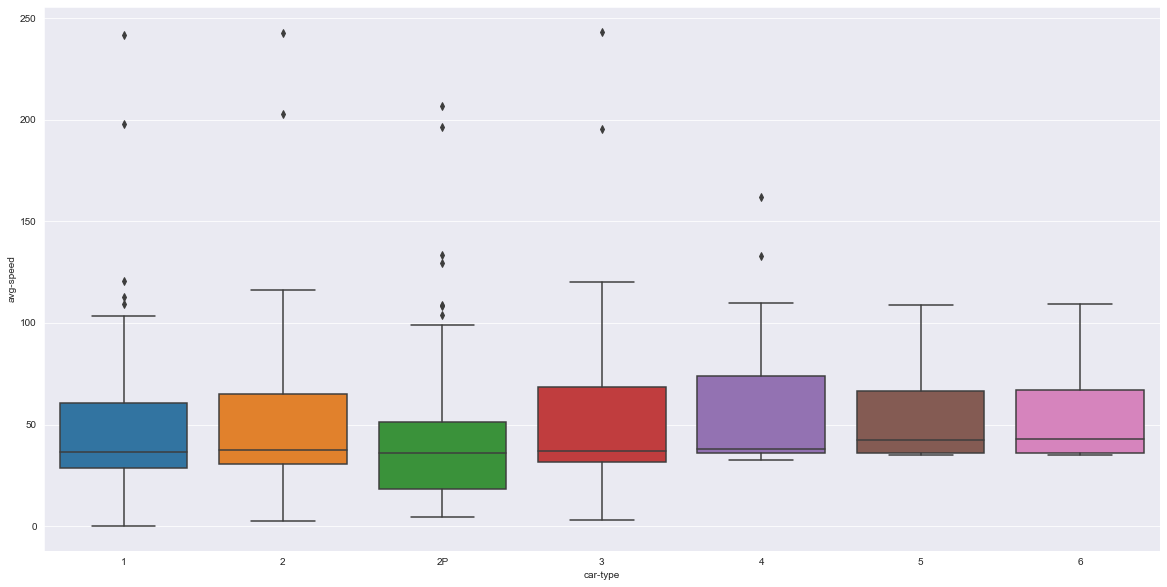

In [259]:
sns.boxplot(x=speed_df['car-type'], y=speed_df['avg-speed'])


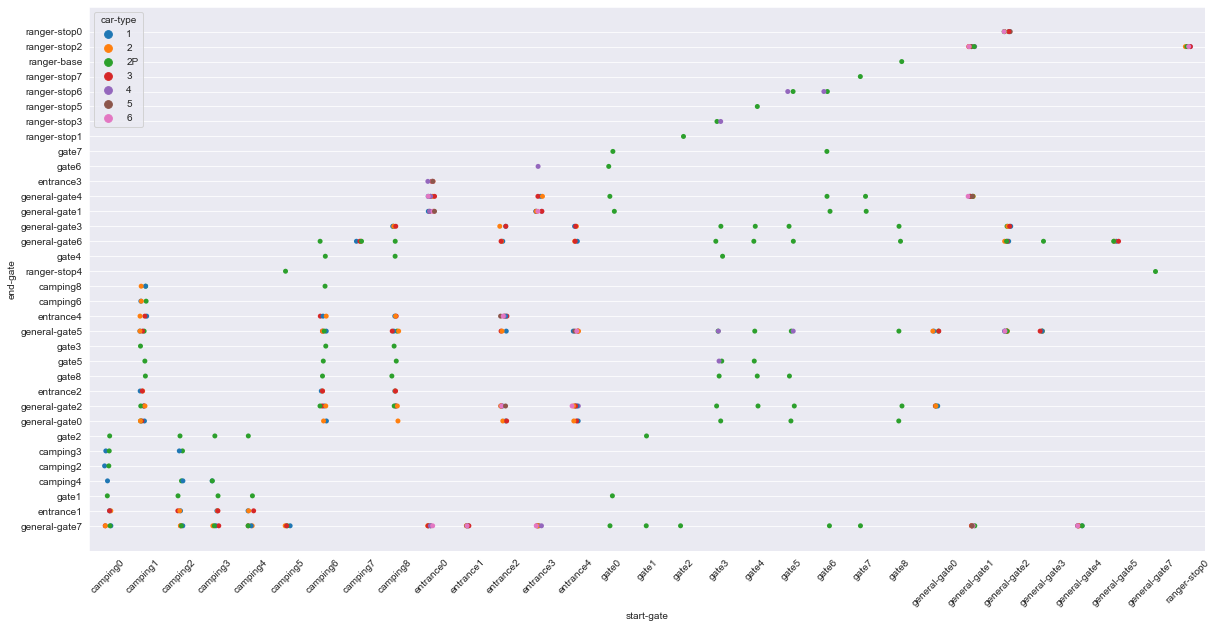

In [260]:
sns.stripplot(x=speed_df['start-gate'], y=speed_df['end-gate'], hue=speed_df['car-type'])
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='car-type', ylabel='avg-speed'>

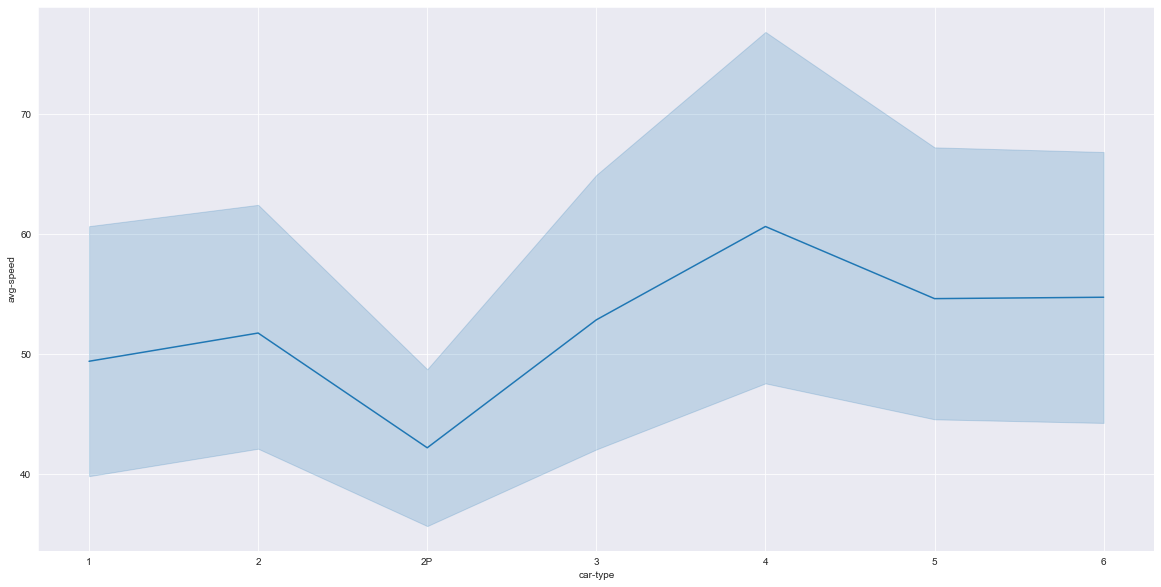

In [269]:
sns.lineplot(x=speed_df['car-type'], y=speed_df['avg-speed'])
#The type of car with the lowest average speed is 2P, or, the park service vehicles.
#The type of car with the highest average speed is 4, or, 4 axel trucks (trucks with 8 to 14 wheels)
#Larger vehicles tend to travel at higher speeds through the preserve, this may be due to the fact that smaller, passenger cars are
#interested in the view of their surrounding while driving or that they are unfamiliar with the area

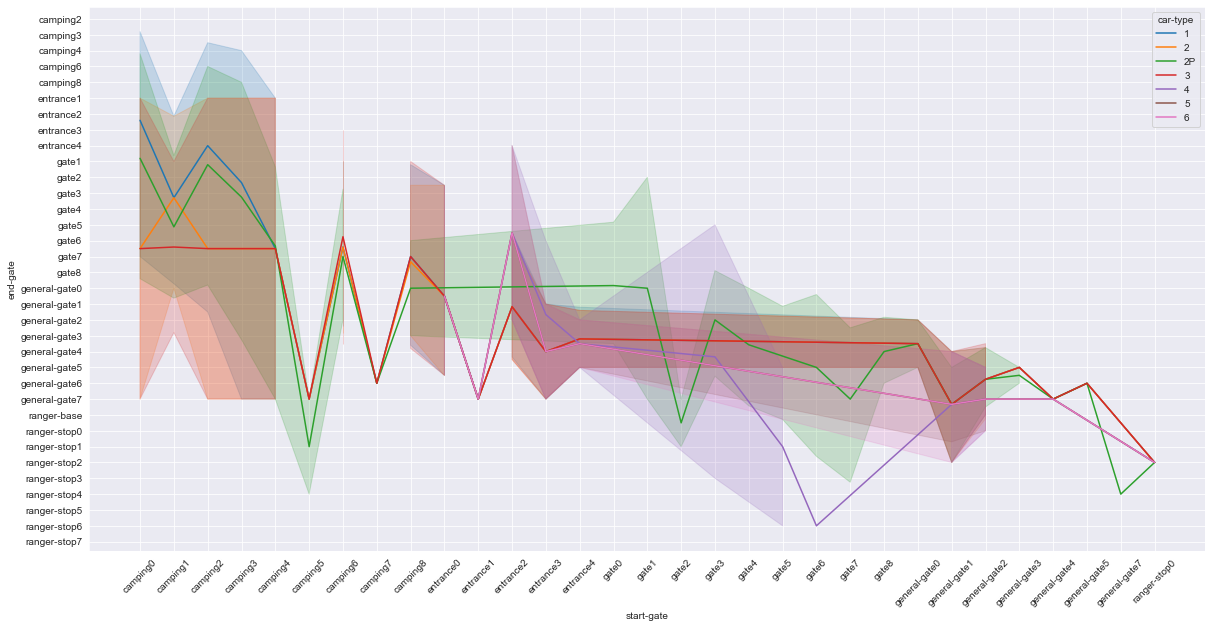

In [267]:
sns.lineplot(x=speed_df['start-gate'], y=speed_df['end-gate'], hue=speed_df['car-type'])
plt.xticks(rotation=45)
plt.show()

In [182]:
#dictionary with timestamp as key
time_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    time_dict[data['Timestamp'][x]].append((data['car-id'][x], data['gate-name'][x], data['car-type'][x]))


In [183]:
#dictionary with vehicle type as key
car_type_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    car_type_dict[data['car-type'][x]].append((data['Timestamp'][x], data['gate-name'][x], data['car-id'][x]))

In [184]:
#dictionary with sensor name as key
gate_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    gate_dict[data['gate-name'][x]].append((data['car-id'][x], data['Timestamp'][x], data['car-type'][x]))



In [185]:
# track individual cars
print("Number of individual cars:",len(data['car-id'].unique()))

Number of individual cars: 18708


<AxesSubplot:xlabel='month', ylabel='count'>

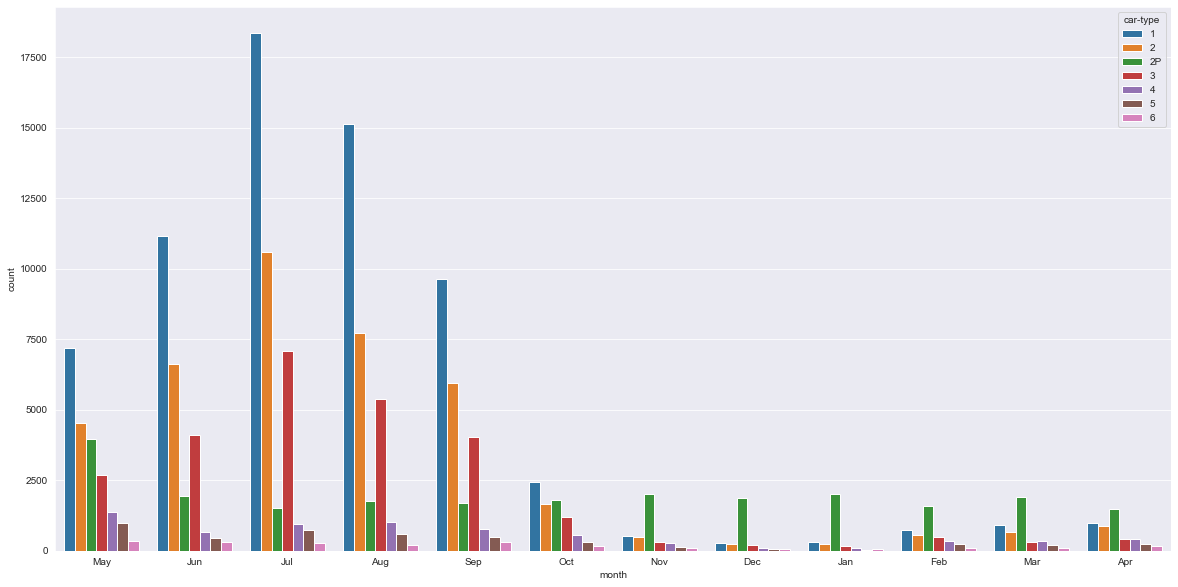

In [186]:
# visualize data overall
sns.countplot(x=data.month, hue=data['car-type'])

<AxesSubplot:xlabel='months'>

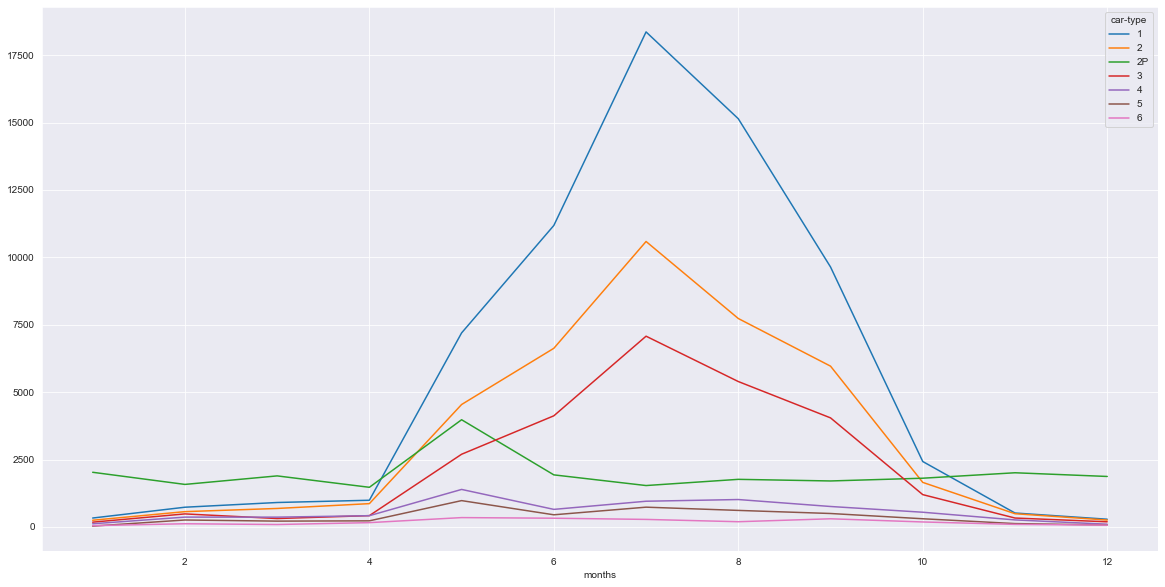

In [187]:
p = data.groupby(['months', 'car-type']).size()
p.head()
p.unstack().plot(legend=True)
# starting in April, tourism increases, peaks in July, and crashes to November.

<AxesSubplot:xlabel='days'>

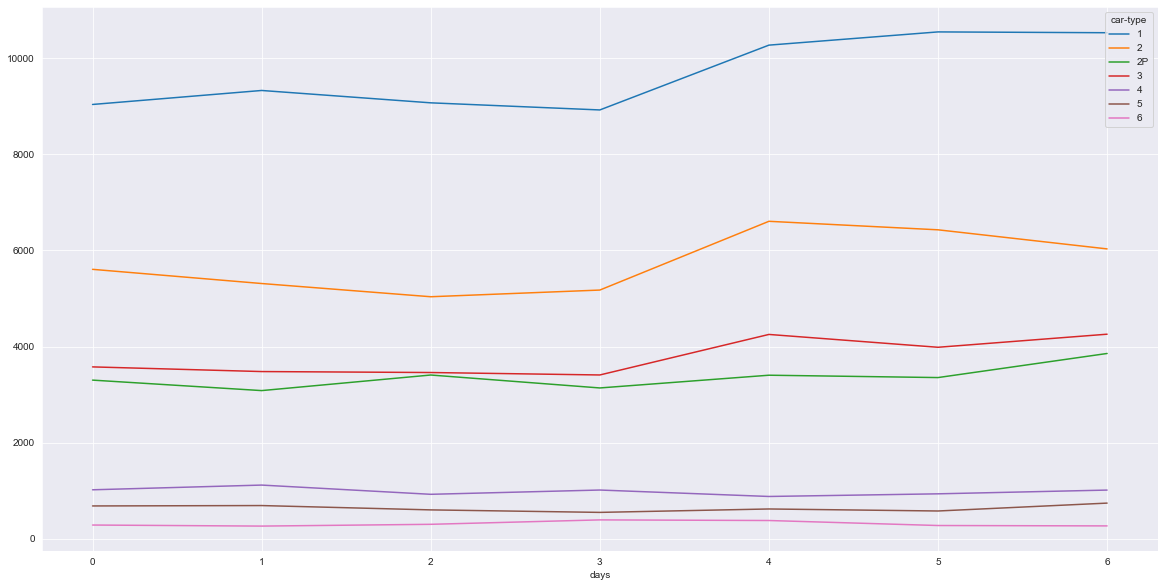

In [188]:
l = data.groupby(['days','car-type']).size()
l.unstack().plot(legend=True)
# Weekends are more popular; count starts at Monday with 0 

<AxesSubplot:xlabel='months,days'>

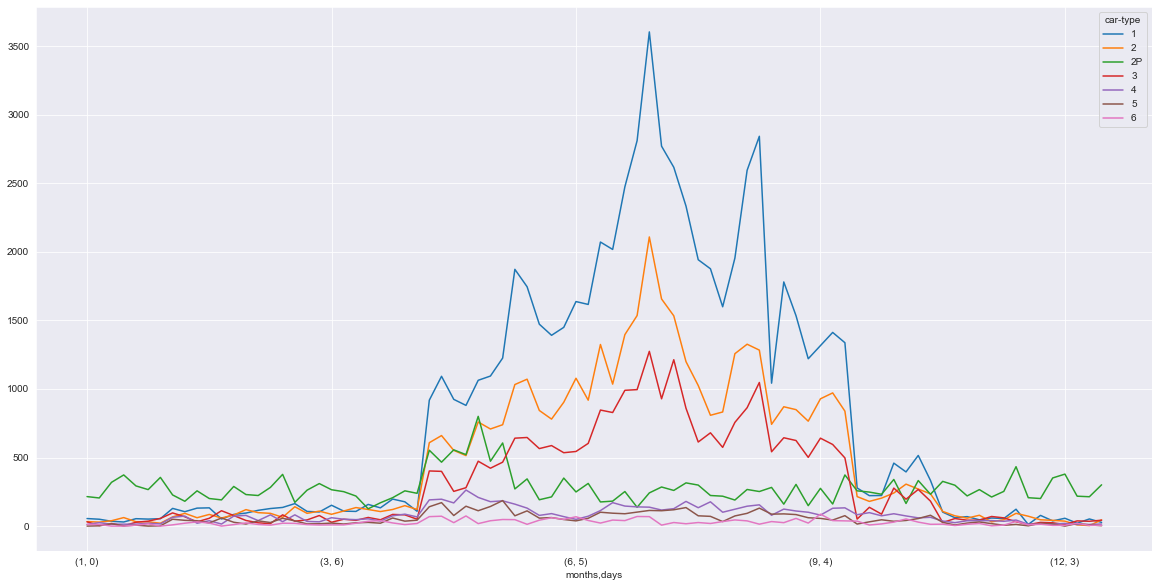

In [189]:
m = data.groupby(['months','days','car-type']).size()
m.unstack().plot(legend=True)
# we can conclude that bus activity stays constant;
# regular car activity really picks up in April and ends around October;
# ranger activity also is more active in April compared to other months; maybe this is disturbing nesting?

<AxesSubplot:xlabel='hours'>

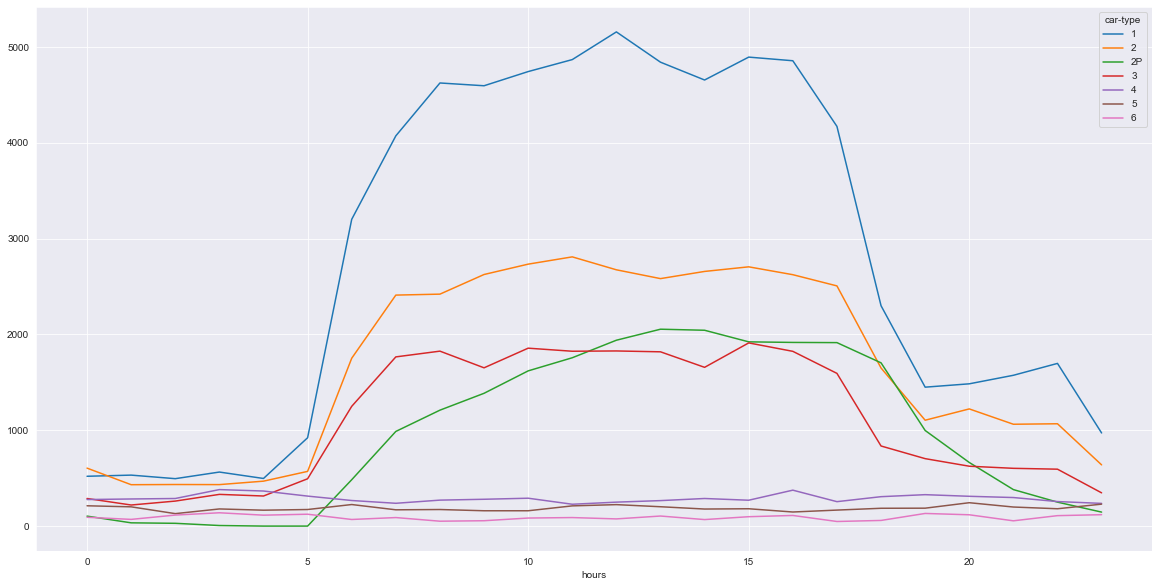

In [190]:
n = data.groupby(['hours', 'car-type']).size()
n.unstack().plot(legend=True)
# we can conclude that the most popular times to visit the park are between 7am and 5pm; 
# ranger activity also follows this trend but bus and 4 axle truck activity are pretty much constant

               Timestamp              car-id car-type      gate-name month  \
days                                                                         
4    2015-05-01 00:43:28  20154301124328-262        4      entrance3   May   
4    2015-05-01 01:03:48  20154301124328-262        4  general-gate1   May   
4    2015-05-01 01:06:24  20154301124328-262        4   ranger-stop2   May   
4    2015-05-01 01:09:25  20154301124328-262        4   ranger-stop0   May   
4    2015-05-01 01:12:36  20154301124328-262        4  general-gate2   May   

         day  hours  months         gates   cars  
days                                              
4     Friday      0       5      entrance  truck  
4     Friday      1       5  general_gate  truck  
4     Friday      1       5   ranger_stop  truck  
4     Friday      1       5   ranger_stop  truck  
4     Friday      1       5  general_gate  truck  


<AxesSubplot:xlabel='days'>

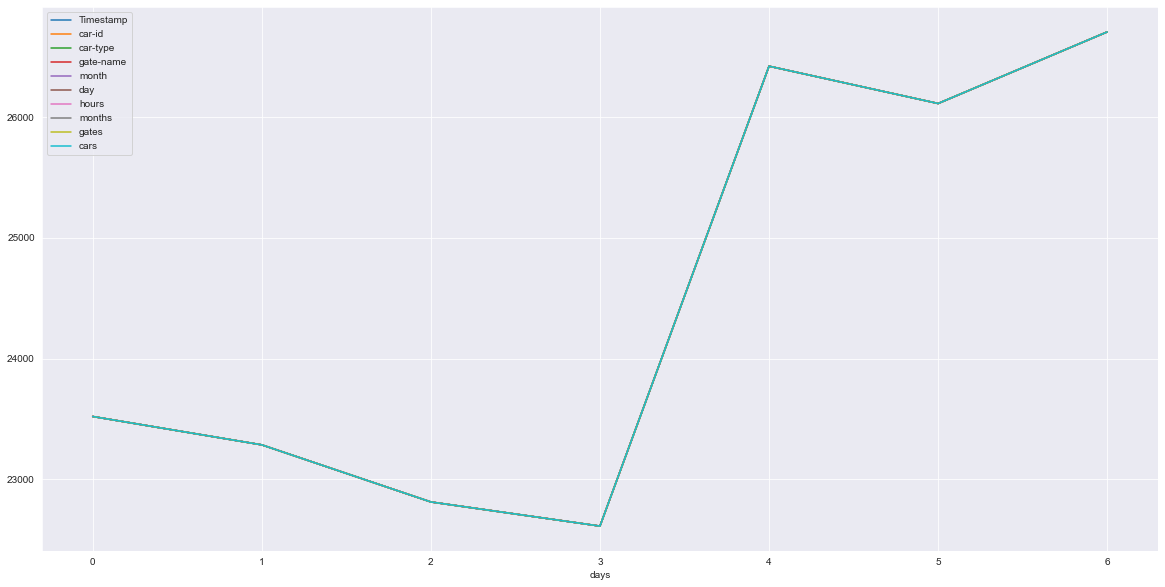

In [191]:
graph = data.set_index('days')
print(graph.head())
graph.groupby('days').count().plot()
# we can conclude that weekends are the most heavily visited time
# reminder that the "day" count starts at 0 on Monday

<AxesSubplot:xlabel='gate-name'>

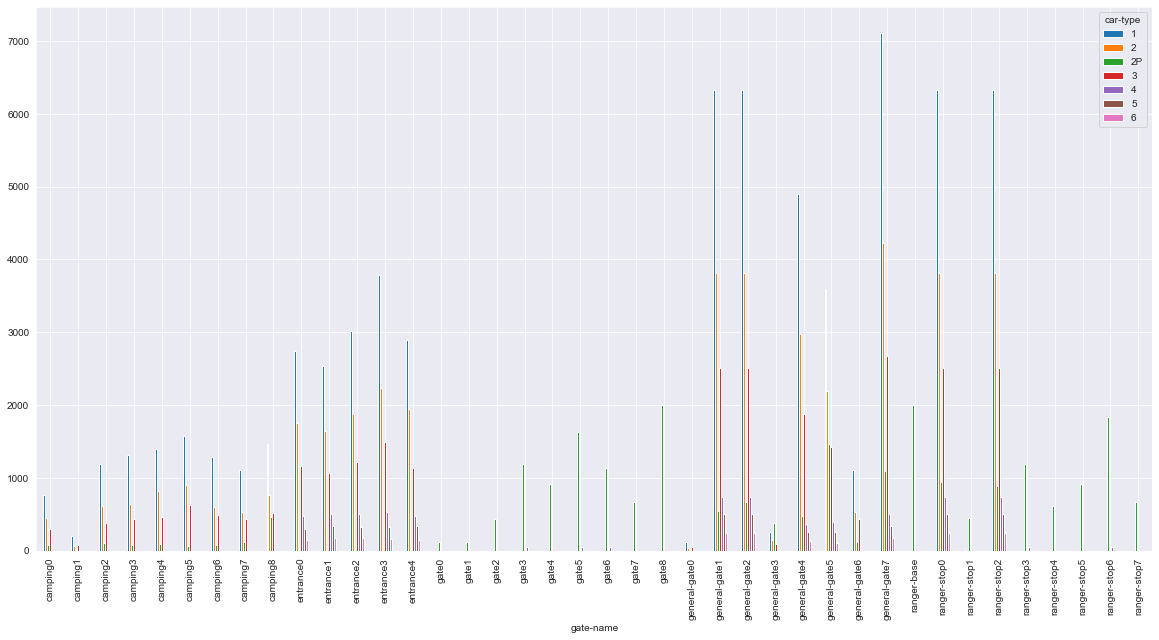

In [192]:
j = data.groupby(['gate-name','car-type']).size()
j.unstack().plot.bar(legend=True)
# This indicates that general gate 7 is the gate that most people drive through. 
# there are some suspicious non-ranger activities in ranger stop 0 and ranger stop 2, but those two ranger 
# stops seem to be on the main roads, so maybe that is expected.
# It makes sense that the most popular gate is gate 8, which leads to the ranger base
# General Gate 0, General Gate 3, and the Camping 1 stop seem surprisingly unpopular; 
# seems like not many people go up that loop.

In [193]:
#Unneeded code for now.
#Keeping just in case.


#create graph class

# class Graph(object):
#
#     def __init__(self, graph_dict=None):
#         if graph_dict == None:
#             graph_dict = {}
#         self._graph_dict = graph_dict
#     def edges(self, vertex):
#         return self._graph_dict[vertex]
#     def all_vertices(self):
#         return set(self._graph_dict.keys())
#     def all_edges(self):
#         return self._generate_edges()
#     def add_vertex(self, vertex):
#         if vertex not in self._graph_dict:
#             self._graph_dict[vertex] = []
#     def add_edge(self, edge):
#         edge = set(edge)
#         v1, v2 = tuple(edge)
#         for x, y in [(v1, v2), (v2, v1)]:
#             for x in self._graph_dict:
#                 self._graph_dict[x].add(y)
#             else:
#                 self._graph_dict[x] = [y]
#     def _generate_edges(self):
#         edges = []
#         for vertex in self._graph_dict:
#             for neighbor in self._graph_dict[vertex]:
#                 if {neighbor, vertex} not in edges:
#                     edges.append({vertex, neighbor})
#         return edges
#     def __iter__(self):
#         self._iter_obj = iter(self._graph_dict)
#         return self._iter_obj
#     def __next__(self):
#         return next(self._iter_obj)
#     def __str__(self):
#         res = "vertices: "
#         for k in self._graph_dict:
#             res += str(k) + " "
#         res += "\nedges: "
#         for edge in self._generate_edges():
#             res += str(edge) + " "
#         return res
#
#
# g = Graph(g)

<AxesSubplot:xlabel='months', ylabel='car-type'>

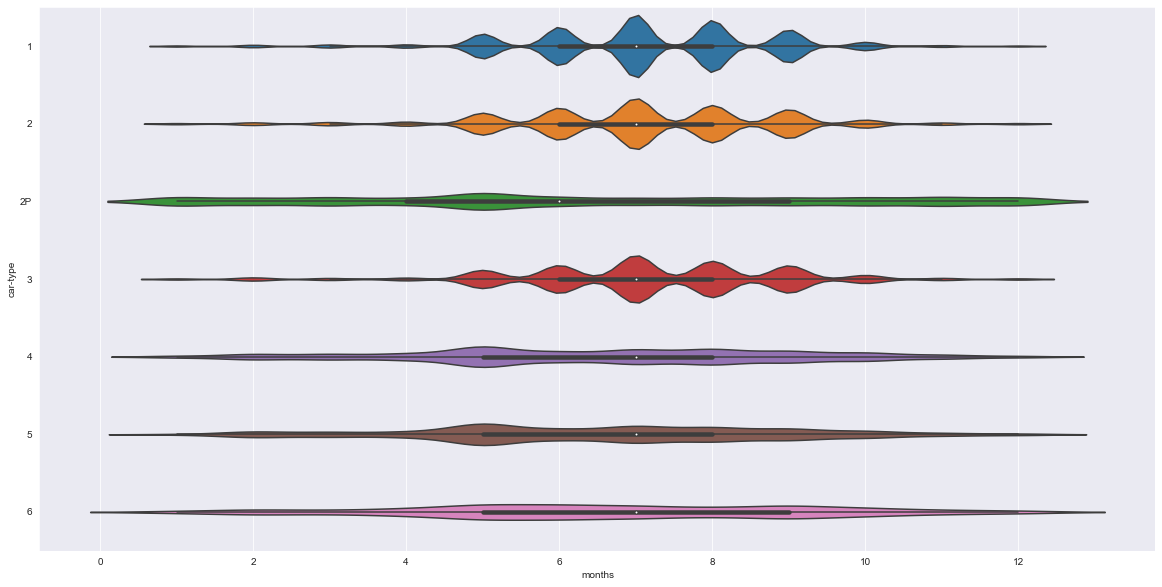

In [194]:
sns.violinplot(x=data.months, y=data['car-type'])
# another way to show the trends of car type and activity in certain months.
# we can again see that more ranger activity, and other activity starts in April, which may affect nesting

<AxesSubplot:xlabel='car-type', ylabel='days'>

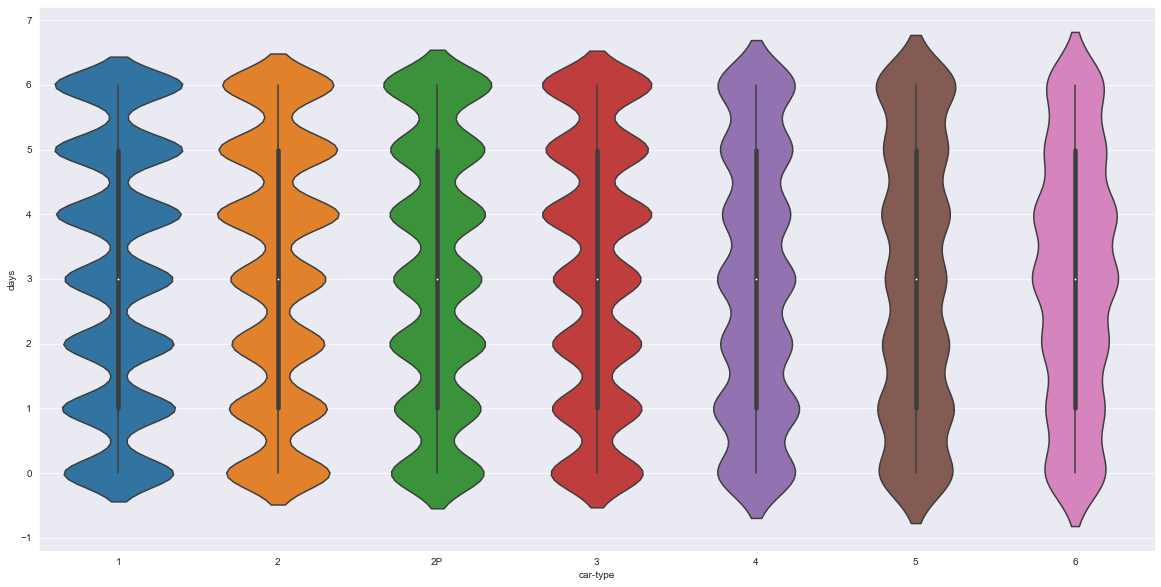

In [195]:
sns.violinplot(y=data.days, x=data['car-type'])
# not sure this really gives us any information other than the fact that bus activity is maybe less 
# present on the weekends but car activity is more present on weekends

<AxesSubplot:xlabel='days', ylabel='gates'>

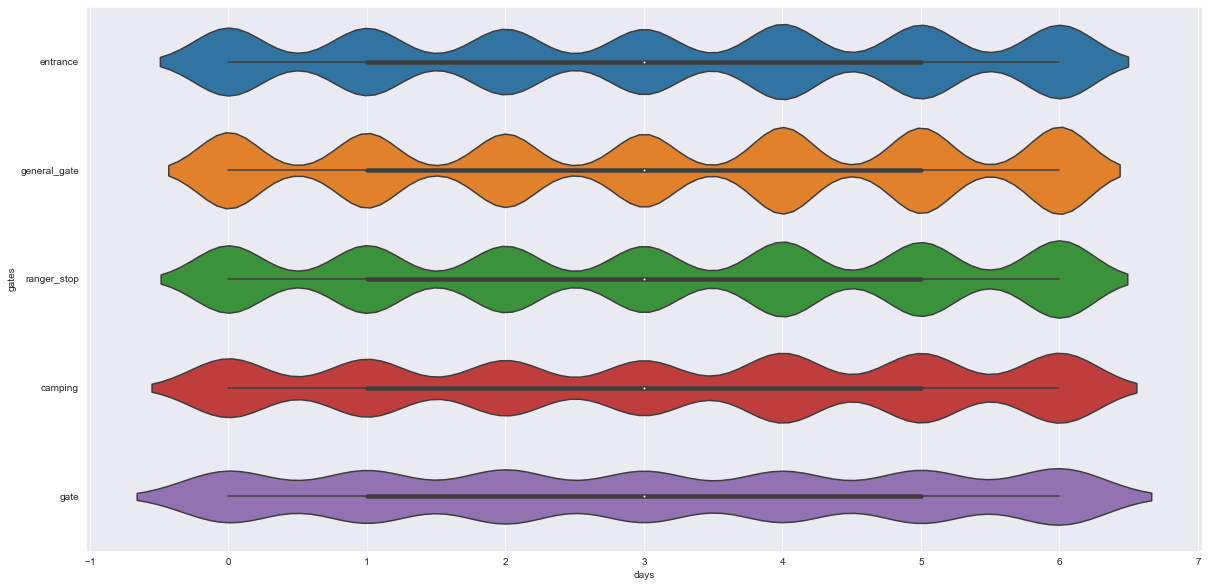

In [196]:
sns.violinplot(y=data['gates'], x=data.days)
# this indicates that all are a bit more used on the weekends, as is all roadway
# however, plain "gates" are pretty constant, which makes sense because they are reserved for ranger use

<AxesSubplot:xlabel='gates'>

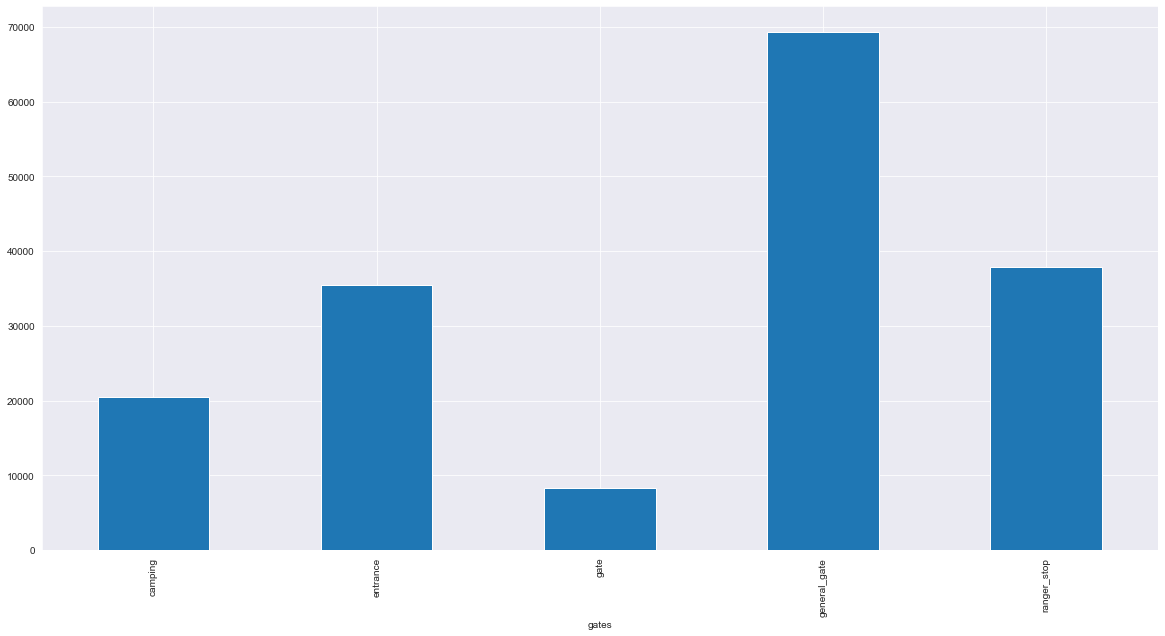

In [197]:
b = data.groupby(['gates']).size()
b.plot.bar()
# not sure this plot adds any value

<AxesSubplot:xlabel='gates'>

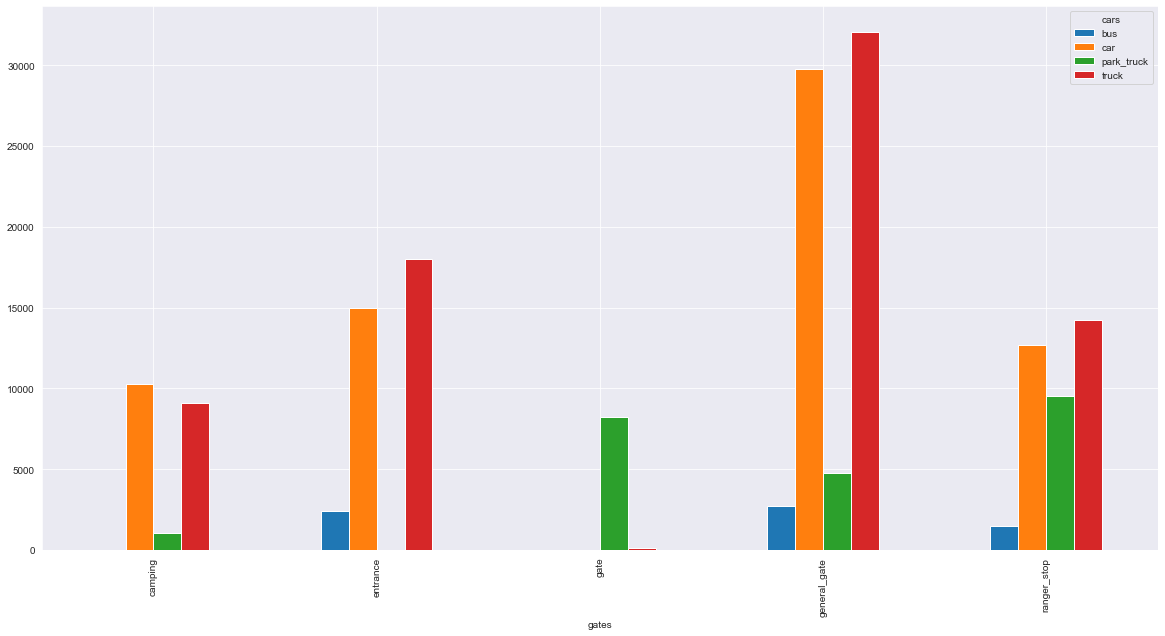

In [198]:
a = data.groupby(['gates','cars']).size()
a.unstack().plot.bar(legend=True)
# looks like occasionally, trucks that are not park trucks get through gates; this could be to bring
# supplies to the ranger station. 

In [17]:
# find any non-authorized cars to the ranger stations
data[(data['car-type']!='2P') & (data['gates']=='gate')].count()[0]
data[(data['car-type']!='2P') & (data['gates']=='gate')]['car-id'].unique()

unauth = data[(data['car-type']!='2P') & (data['gates']=='gate')]['car-id']
unauth.describe()

count                    138
unique                    23
top       20150505020522-625
freq                       6
Name: car-id, dtype: object